## Theme Extraction Pipeline (High Level)

- **Prepare text** → Clean and lemmatize customer reviews for linguistic consistency

- **Embed reviews** → Convert text into semantic vectors using sentence transformers

- **Discover structure** → Cluster embeddings to identify distinct customer contexts using hierarchical clustering

- **Focus context** → Select the dominant semantic cluster representing core experience

- **Extract themes** → Use TF-IDF + NMF and noun phrases to uncover latent themes within the main cluster

- **Label themes** → Generate business-ready summaries, likes, dislikes, and impact using LLM

---

## Execution Flow by Section

**Section 1: Setup** → Load libraries and initialize Spark  
**Section 2: Data Loading** → Fetch reviews for target business  
**Section 3: Text Preprocessing** → Clean reviews, remove noise, add linguistic features  
**Section 4: Embedding** → Convert cleaned text to semantic vectors  
**Section 5: Context Discovery** → Hierarchical clustering to find semantic groups  
**Section 6: Context Filtering** → Extract dominant cluster with core feedback  
**Section 7: Theme Discovery** → TF-IDF and noun phrase extraction within context  
**Section 8: Theme Labeling** → LLM generates human-readable theme summaries  
**Section 9: Results** → Display labeled themes and insights

## Import Libraries

**Next cells:** Load NumPy, Pandas, Matplotlib, PySpark, and custom modules for the pipeline.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

from pyspark.sql import SparkSession
from pyspark.sql.functions import size
import os, sys

In [2]:
PROJECT_ROOT = Path.cwd().parents[1]  # Go up to project root
sys.path.insert(0, str(PROJECT_ROOT))

from src.data.my_reviews_loader import BusinessReviewLoader
from src.preprocessing.my_preprocessor import MyPreProcessor
from src.preprocessing.feature_engineering import MyFeatureEngineering
from src.embeddings.my_sentence_transformer import MySentenceTransformer
from src.core.business_context_clusterer import BusinessContextClusterer
from src.core.clustering_evaluator import ClusteringEvaluator
from src.embeddings.embedding_space_normalizer import EmbeddingSpaceNormalizer
from src.core.theme_discovery_engine import ThemeDiscoveryEngine
from src.core.theme_labeler import ThemeLabeler

In [3]:
# Initialize Spark Session with Increased Driver Memory
spark = SparkSession.builder \
    .appName('ReviewsProcessing') \
    .config('spark.driver.memory', '8g') \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/01/10 23:42:56 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Load Reviews

**Next cells:** Load Yelp business and review data for a specific business ID using the BusinessReviewLoader.

In [4]:
# LOAD REVIEWS
loader = BusinessReviewLoader(
    business_path="../../data/raw/yelp_academic_dataset_business.json",
    reviews_path="../../data/raw/yelp_reviews.parquet"
)

# biz_reviews = loader.get_reviews_by_business_id("_ab50qdWOk0DdB6XOrBitw") # zootampa at lowry park # grand sierra resort and casino

# Datz: QHWYlmVbLC3K6eglWoHVvA
biz_reviews = loader.get_reviews_by_business_id("QHWYlmVbLC3K6eglWoHVvA")

26/01/10 23:42:57 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [5]:
biz_reviews.shape

(3388, 9)

## Preprocess Reviews

**Next cell:** Clean reviews (lowercase, remove punctuation, filter short reviews) using MyPreProcessor.

In [6]:
# PREPROCESS
preprocessor = MyPreProcessor(min_words=3)
clean_reviews = preprocessor.prepare(biz_reviews)

## Add Linguistic Features

**Next cells:** Add lemmatization, extract noun phrases, and compute linguistic features using MyFeatureEngineering.

In [7]:
feature_engineer = MyFeatureEngineering()
clean_reviews = feature_engineer.add_features(clean_reviews)

In [8]:
clean_reviews.business_id.value_counts()

business_id
QHWYlmVbLC3K6eglWoHVvA    3388
Name: count, dtype: int64

## Embed Reviews

**Next cells:** Initialize MySentenceTransformer and convert cleaned review text to semantic embeddings (384-dim vectors).

In [9]:
embedder = MySentenceTransformer()

In [10]:
X = embedder.transform_sentences(clean_reviews["text_cleaned"].tolist())

## Discover Semantic Structure

**Next cells:** Use hierarchical clustering (dendrograms) to identify distinct semantic contexts in reviews. Find optimal cut height to separate foreign languages and off-topic reviews from main business context.

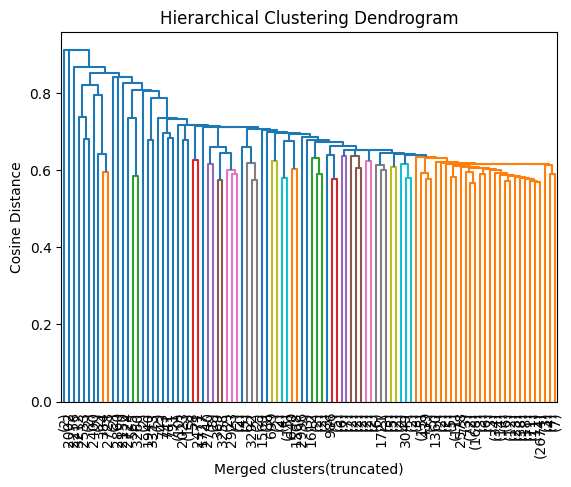

In [11]:
clusterer = BusinessContextClusterer()

Z = clusterer.get_dendrogram(X)
clusterer.plot_dendrogram(Z)
plt.show()

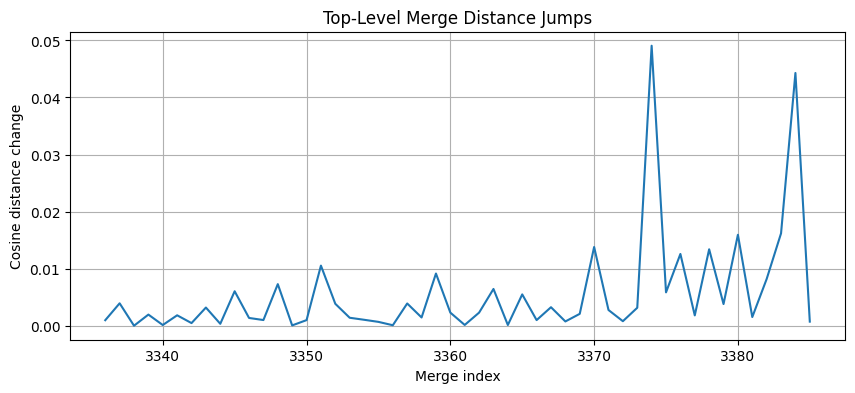

In [12]:
# plot top-level merge jumps only
clusterer.plot_merge_distance_jumps(Z, 50)

In [13]:
cut_height = clusterer.detect_cut_height(Z)

In [14]:
cut_height

0.7350005450016281

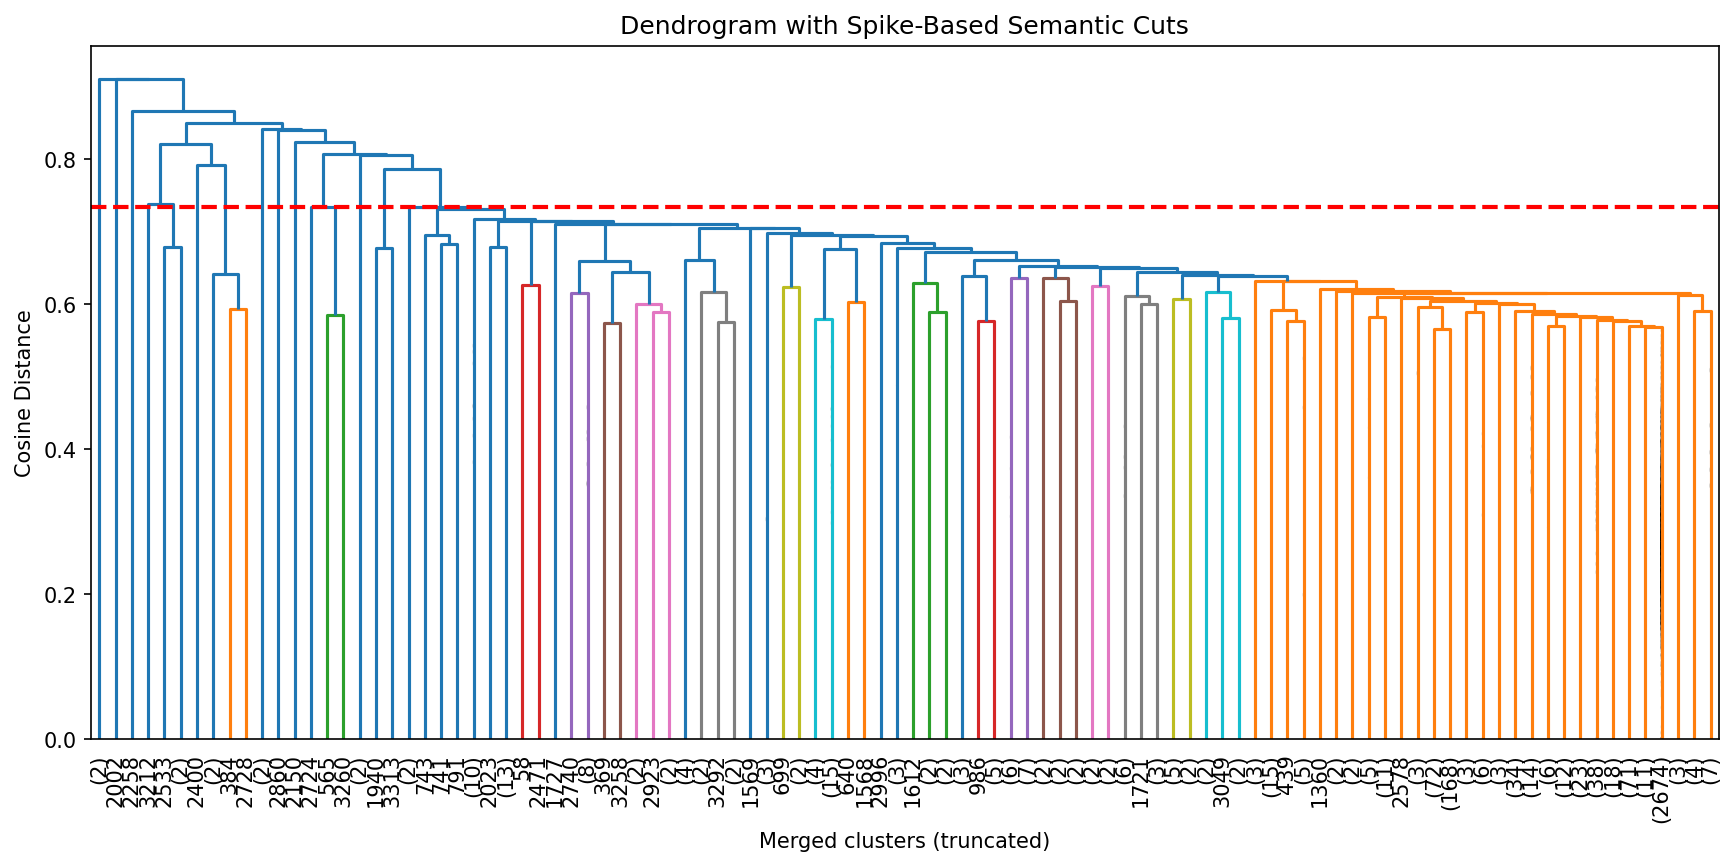

In [15]:
clusterer.plot_dendrogram_with_spikes(Z, cut_height)

In [16]:
# Pick a cut
best_cut = cut_height

In [17]:
labels = clusterer.cut_clusters(X, cut_height=best_cut)

In [18]:
cluster_sizes = pd.Series(labels).value_counts()
cluster_sizes

0     3364
3        4
1        3
4        2
5        2
2        2
10       2
9        2
11       1
7        1
8        1
12       1
14       1
13       1
6        1
Name: count, dtype: int64

In [19]:
primary_context_id = cluster_sizes.idxmax()
primary_context_id

0

In [20]:
other_contexts = clean_reviews[labels != primary_context_id]

In [21]:
# foreign languages observed in the other conte)xts for this business
pd.set_option('display.max_colwidth', 200)
other_contexts.text.head(30)

384     Datz I love you so much. Been here a handful of times now and have never been I satisfied. Everything I've ordered has been great and to be honest I'm torn about trying new things or sticking with...
565                                                                                                                          Over rated way too long of a wait.  Honestly, its just a deli with a Hipster shawl
963                                                                                                                    I had bugs with my meal flying around my house...little knat like bugs!!! Never again!!!
1002                                                                                                 Here for three days and came back for seconds. Definitely need to text ahead to avoid the 90+ minute wait.
1940                                                                                                 Sweet baby jesus!!!!! Datchos... because datchos! Yes, get them, en

## Focus on Main Context

**Next cells:** Extract only reviews from the dominant semantic cluster (main business context) for theme extraction. This filters noise and non-relevant language contexts.

In [22]:
main_reviews = clean_reviews[labels == primary_context_id].reset_index(drop=True)
X_main = X[labels == primary_context_id]

In [23]:
main_reviews.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,text_cleaned,lemmas,word_count,char_count,avg_word_length,sentence_count
0,BuGPwZ8qkjUlflllV6i0dA,pFZhFkV0ReZAXM_OXcqQsw,QHWYlmVbLC3K6eglWoHVvA,3.0,0,0,0,Call first and get on the waiting list because waiting is long. Food was good not great. We ordered chicken and waffles. Waffles were more like pancakes except in waffles shape. Monkey bread was t...,2016-09-06 00:49:59,call first and get on the waiting list because waiting is long. food was good not great. we ordered chicken and waffles. waffles were more like pancakes except in waffles shape. monkey bread was t...,call first get waiting list waiting long food good not great order chicken waffle waffle like pancake except waffle shape monkey bread tough burger great,39,222,4.717949,5
1,ju_VtogulmyTCjpbh6k97A,lB5xIdPKZXbWqoqvgAoGyg,QHWYlmVbLC3K6eglWoHVvA,5.0,0,0,0,"Great atmosphere and this place has a strong drinks game. Meal portions are large, service snappy and the menu gives you all the great American staples with plenty of twists. Had the meat loaf...i...",2015-06-21 00:27:21,"great atmosphere and this place has a strong drinks game. meal portions are large, service snappy and the menu gives you all the great american staples with plenty of twists. had the meat loaf...i...",great atmosphere place strong drink game meal portion large service snappy menu give great american staple plenty twist meat loaf money,36,208,4.805556,6
2,uG-EOL7nrCDFfLlOQMCcrA,XrtCszxXH35oTHOKpG_bBA,QHWYlmVbLC3K6eglWoHVvA,1.0,3,0,0,Never got around to the food because it was the worst service I've had in a long time. First the hostess didn't say hi when we walked in as the party in front of us was trying to decide whether to...,2015-08-06 21:57:26,never got around to the food because it was the worst service i have had in a long time. first the hostess did not say hi when we walked in as the party in front of us was trying to decide whether...,never get around food bad service long time first hostess not say hi walk party front u trying decide whether sit wait friend parking next hostess seat u upstairs corner place half full wait minut...,151,782,4.185430,7
3,QvtYAOh64MhixHiBZsPNKg,PZWQgi8yUM3epd4oThiCDQ,QHWYlmVbLC3K6eglWoHVvA,4.0,0,0,0,"As a northeast transplant, Datz felt like home again to me. Good service, tasty food and drinks, top notch desserts. The food while tasty is sort of one note - rich. Usually busy so go at off peak...",2014-06-27 22:50:37,"as a northeast transplant, datz felt like home again to me. good service, tasty food and drinks, top notch desserts. the food while tasty is sort of one note - rich. usually busy so go at off peak...",northeast transplant datz felt like home good service tasty food drink top notch desserts food tasty sort one note rich usually busy go peak time make reservation,43,225,4.255814,4
4,lyjJdbRqnYSnMp0_HNkwUw,d1x082xNzhbpc2dJJLT4ag,QHWYlmVbLC3K6eglWoHVvA,5.0,0,0,0,"Awesome place. Everything I have had here is great. Burgers, breakfast, Cuban, Ruben you can't go wrong. Make sure you go To dough too....their bakery",2016-08-12 20:48:02,"awesome place. everything i have had here is great. burgers, breakfast, cuban, ruben you cannot go wrong. make sure you go to dough too....their bakery",awesome place everything great burger breakfast cuban ruben not go wrong make sure go dough bakery,25,151,5.080000,7


In [24]:
X_main.shape

(3364, 384)

## KMeans Clustering Within Main Context

**Next cells:** Normalize embeddings via PCA, probe optimal k value using elbow method, then perform final KMeans clustering to identify sub-themes within the main business context.

In [25]:
normalizer = EmbeddingSpaceNormalizer()

X_main_cluster = normalizer.fit_transform(X_main)

In [26]:
print("Variance retained:", normalizer.variance_retained())

Variance retained: 0.91225255


In [27]:
evaluator = ClusteringEvaluator()

results = evaluator.probe_k_range(
    X_raw=X_main,
    X_cluster=X_main_cluster,
    k_values=range(6, 15),
    method="kmeans",
)


Evaluating kmeans | k=6...
Evaluating kmeans | k=7...
Evaluating kmeans | k=8...
Evaluating kmeans | k=9...
Evaluating kmeans | k=10...
Evaluating kmeans | k=11...
Evaluating kmeans | k=12...
Evaluating kmeans | k=13...
Evaluating kmeans | k=14...


In [28]:
results

,k,method,linkage,avg_intra_cosine,inter_centroid_cosine,cluster_size_std
0,6,kmeans,None,0.484174,0.892352,448.423411
1,7,kmeans,None,0.503339,0.889530,294.305408
2,8,kmeans,None,0.501168,0.893827,203.628338
3,9,kmeans,None,0.509433,0.854931,302.154404
4,10,kmeans,None,0.514600,0.847843,265.339481
5,11,kmeans,None,0.506913,0.874081,238.921371
6,12,kmeans,None,0.530130,0.855010,146.007610
7,13,kmeans,None,0.519448,0.851795,175.546686
8,14,kmeans,None,0.516842,0.870742,154.567336


In [29]:

k = np.array(results["k"])
y = np.array(results["inter_centroid_cosine"])

# Normalize
k_norm = (k - k.min()) / (k.max() - k.min())
y_norm = (y - y.min()) / (y.max() - y.min())


In [30]:
# Line endpoints
p1 = np.array([k_norm[0], y_norm[0]])
p2 = np.array([k_norm[-1], y_norm[-1]])

# Distance from line
distances = []
for i in range(len(k_norm)):
    p = np.array([k_norm[i], y_norm[i]])
    distance = np.abs(np.cross(p2 - p1, p1 - p)) / np.linalg.norm(p2 - p1)
    distances.append(distance)

elbow_k = k[np.argmax(distances)]
elbow_k


10

In [31]:

kmeans_model, labels = evaluator.fit_final_clustering(
    X_cluster=X_main_cluster,
    k=elbow_k,
    method="kmeans"
)

main_reviews["theme_id"] = labels


In [32]:
main_reviews.groupby("theme_id").size().sort_values(ascending=False)


theme_id
1    953
9    574
0    471
3    457
4    273
6    181
5    177
8    136
7     79
2     63
dtype: int64

## Theme Discovery

**Next cells:** Load OpenAI client, extract TF-IDF terms and noun phrases from each cluster, then use LLM to generate business-ready theme labels with summaries of likes/dislikes.

In [33]:
# Load .env
from dotenv import load_dotenv
load_dotenv()

from openai import OpenAI
client = OpenAI()

In [34]:
theme_ids = (
    main_reviews["theme_id"]
    .value_counts()
    .sort_index()
    .index
)
theme_ids

Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype='int32', name='theme_id')

In [35]:
theme_cards = []

engine = ThemeDiscoveryEngine()

texts_all_modeling = main_reviews["lemmas"].tolist()
texts_all_display  = main_reviews["text"].tolist()

engine.fit_global_tfidf(texts_all_modeling)

In [36]:
theme_cards = []

for theme_id in sorted(main_reviews["theme_id"].unique()):
    theme_df = main_reviews[main_reviews["theme_id"] == theme_id]

    # Semantic guard still belongs here (business logic)
    if len(theme_df) < 10:
        continue

    theme = engine.describe_cluster(
        texts_for_modeling=theme_df["lemmas"].tolist(),
        texts_for_display=theme_df["text"].tolist()
    )

    if not theme["terms"]:
        # Lexically weak cluster — valid outcome
        continue

    theme_cards.append({
        "theme_id": int(theme_id),
        "evidence_count": int(len(theme_df)),
        "terms": theme["terms"],
        "noun_phrases": theme["noun_phrases"],
        "examples": theme["examples"],
    })

In [37]:
labeler = ThemeLabeler(client=client)

labeled_themes = labeler.label_all_themes(theme_cards)

In [38]:
labeled_themes

{0: {'theme_name': 'Datz Dining Experience',
  'theme_category': 'Restaurant Feedback',
  'summary': 'Customers consistently rave about the vibrant atmosphere, unique decor, and large portion sizes at Datz in Tampa. The menu features inventive dishes like the Datchos and The Cheesy Todd, which are highlighted for their delicious flavors and creative presentations. While the food quality is generally praised, some diners express disappointment with limited menu options during brunch and the absence of preferred sides like french fries.',
  'likes': ['Vibrant and energetic atmosphere',
   'Unique and eclectic decor',
   'Large portion sizes',
   'Inventive menu items',
   'Friendly and prompt service'],
  'dislikes': ['Limited menu options during brunch',
   'Absence of preferred sides like french fries',
   'Occasional service oversights'],
  'business_impact': "Positive customer experiences and strong word-of-mouth recommendations enhance Datz's reputation as a must-visit restaurant in

#### Theme Results: 

- Theme 0 -> 'Trendy Dining Experience in Tampa',

- Theme 1 -> 'Food Quality and Service Experience',

- Theme 2 -> 'Mixed Dining Experience at Datz',

- Theme 3 -> 'Unique and Delicious Menu Offerings',

- Theme 4 -> 'Brunch Experience at Datz',

- Theme 5 -> 'Breakfast Quality and Experience',

- Theme 6 -> 'Inconsistent Service and Experience',

- Theme 7 -> 'Reuben Sandwich Experience',

- Theme 8 -> 'Sandwiches and Service Experience',

- Theme 9 -> 'Food Quality and Service Experience',


## Conclusions and Next Steps

### Key Conclusions

- The current pipeline successfully identifies **dominant semantic patterns** in customer reviews using embedding-based clustering and deterministic lexical signals.
- At the **review level**, extracted themes represent **aggregated customer experiences**, not singular intents. Individual reviews frequently mention multiple aspects (e.g., food quality, service, atmosphere).
- As a result, **theme overlap is expected** and reflects a **data property**, not a modeling flaw.
- The quality and separability of discovered themes are therefore **bounded by the unit of analysis**, not by clustering or labeling choices.
- LLM-based labeling provides a useful **semantic summarization layer**, but cannot fully disentangle themes when the underlying units are multi-themed.

---

## Phase 2 — Changing the Unit of Analysis

### Motivation

The core limitation of the current system is **review-level granularity**. Reviews do not guarantee a single semantic intent, which limits cluster purity and downstream business interpretation.

**Phase 2 transitions the unit of analysis from reviews to sentences (or noun-phrase–anchored sentences).**

This change enables:
- clearer semantic intent per unit  
- reduced thematic overlap  
- more precise attribution of likes and dislikes  
- improved alignment between semantic clusters and business actions  

This is a structural improvement to the data representation, not a change in modeling philosophy.

---

## Scale Considerations and Clustering Transition

### Caveat: Review-Level Methods Do Not Scale to Sentences

Sentence segmentation increases data volume significantly (often **3–10×**).  
At this scale (e.g., 50k+ sentences per business):

- Hierarchical / agglomerative clustering becomes infeasible  
  - Time complexity: \(O(n^2)\)  
  - Memory complexity: \(O(n^2)\)

This necessitates a change in clustering strategy.

---

### Transition to HDBSCAN

Phase 2 replaces agglomerative clustering with **HDBSCAN**, which is better suited for large, sentence-level embedding spaces.

**Why HDBSCAN**
- Scales efficiently to large datasets  
- Does not require pre-specifying the number of clusters  
- Explicitly models **noise and low-signal sentences**  
- Handles variable-density clusters common in customer feedback  

**What Changes**
- Clustering algorithm: *Agglomerative → HDBSCAN*  
- Explicit treatment of noise  
- Higher minimum cluster size thresholds  
- Improved cluster purity at scale  

**What Stays the Same**
- Embedding model and distance metric (cosine)  
- Lexical theme description via global TF-IDF  
- LLM-based theme labeling  
- Business interpretation framework  

---

## Immediate Next Steps (Within Current Scope)

- **Sentence Segmentation**  
  Split reviews into sentence-level units (optionally anchored by noun phrases).

- **Scalable Semantic Clustering**  
  Apply HDBSCAN to sentence embeddings to identify dense semantic groupings while filtering noise.

- **Theme Reconstruction**  
  Aggregate sentence-level clusters into clearer, more focused business themes.

- **Quality Evaluation**  
  Assess:
  - cluster coherence  
  - noise ratio  
  - theme stability across runs  
  - reduction in cross-theme leakage  

---

## Summary

The Phase 1 pipeline establishes a strong, interpretable foundation for semantic theme discovery. However, **multi-intent reviews impose a hard ceiling on theme separability**.  
Phase 2 addresses this limitation directly by changing the unit of analysis and adopting **HDBSCAN**, enabling more precise, scalable, and defensible theme extraction without increasing system complexity.

This progression reflects **methodological maturity**, not model churn.
